In [67]:
## Build a Linear Model for Yellow Taxi & HV FHV as the competition goes on


# Try By groupby Daily First

# Then, Try With Location Specified

## AutoRegression for Time Series?

In [68]:
from bokeh.plotting import figure, show
from bokeh.tile_providers import get_provider, Vendors
from bokeh.io import save, reset_output, output_notebook
from sklearn.preprocessing import StandardScaler
import folium
from pyspark.sql import SparkSession
import warnings
warnings.filterwarnings("ignore")
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import col, datediff, round, to_date, lit, desc, date_format, when
import pyspark.sql.functions as F
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

from statsmodels.compat import lzip
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols



from pyspark.sql.types import *
from pyspark.sql.functions import col
from pyspark import SparkContext

# create a spark session (which will run spark jobs)
spark = SparkSession.builder.getOrCreate()

sc = SparkContext.getOrCreate(conf=swan_spark_conf) #Start the spark context
spark.conf.set('spark.sql.execution.arrow.pyspark.enabled', True)
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)



In [69]:
plt.rcParams["figure.figsize"] = (15, 10)

## Fit a Linear Model

Not Ridge Regression Since we want output to be exact number instead of something between (-1,1)

In [70]:

lm_data_weekend = pd.read_parquet("../preprocessed_data/lm_data_weekend.parquet")
lm_data_weekend.iloc[:,1:] = StandardScaler().fit_transform(lm_data_weekend.iloc[:,1:]) ## Standardization, make columns std normal distribution
lm_data_weekend.index = lm_data_weekend.index.astype(str)
lm_data_weekend["HoliDay"] = lm_data_weekend["HoliDay"].astype(int)
## Only 68 are selected as the latter part we remove those weekend data and got 68 remaining, controlled group

lm_data_weekend = lm_data_weekend.iloc[:68,:]  
lm_data_weekend.head(5)

,HoliDay,YellowPicks,YellowEarn,YellowSpeed,YellowDuration,YellowDistance,GreenPicks,HVFHVPicks,FHVPicks
date,,,,,,,,,
2019-02-01,0,2.127072,-5.766167,-0.925192,0.437626,-1.239433,2.698160,1.341342,1.233059
2019-02-02,1,1.111223,-2.171310,0.538351,-0.752811,0.260528,1.772495,1.412321,0.012686
2019-02-03,1,-1.051933,-1.423070,2.194760,-2.130630,1.951741,-0.134967,0.193683,-0.618030
2019-02-04,0,-0.762882,-0.344377,0.323449,-0.711870,-0.061431,0.443308,-1.629837,0.487880
2019-02-05,0,0.204009,0.278763,-0.282346,0.072307,-0.301680,0.254786,-1.803542,0.351943


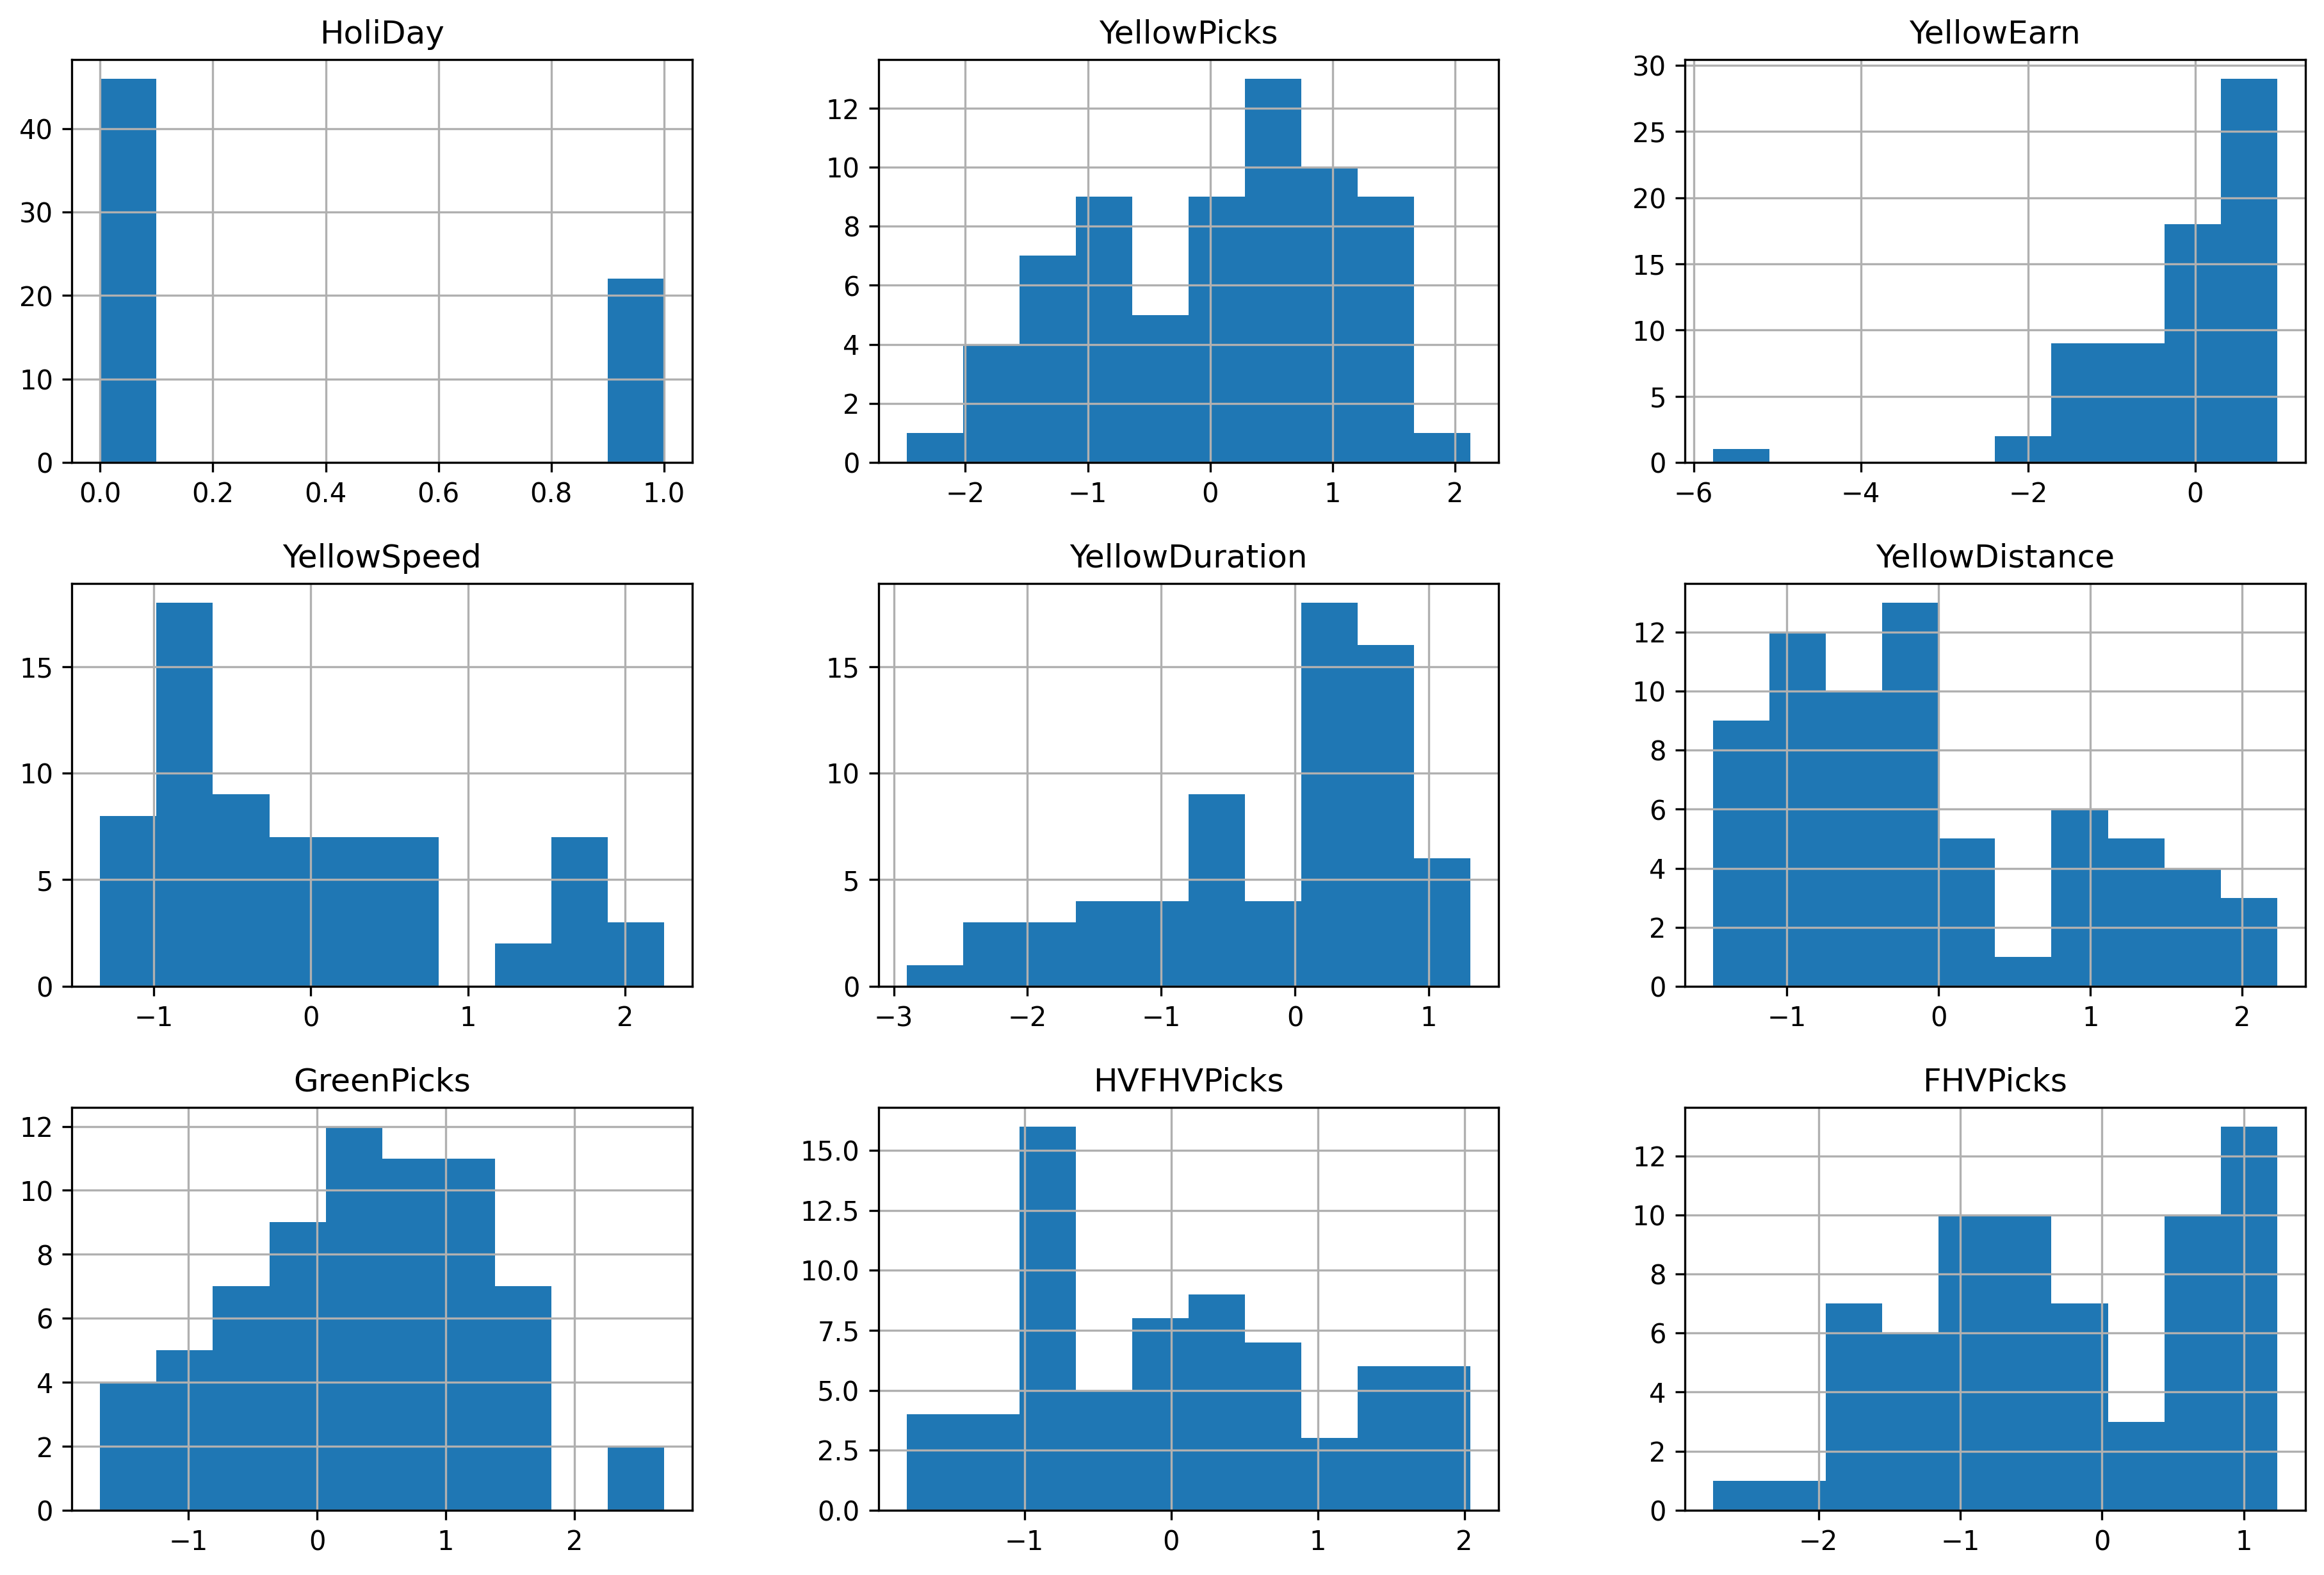

In [71]:
lm_data_weekend.hist()
plt.savefig("../plots/hist.png")

array([[<AxesSubplot:title={'center':'HoliDay'}>,
        <AxesSubplot:title={'center':'YellowPicks'}>,
        <AxesSubplot:title={'center':'YellowEarn'}>],
       [<AxesSubplot:title={'center':'YellowSpeed'}>,
        <AxesSubplot:title={'center':'YellowDuration'}>,
        <AxesSubplot:title={'center':'YellowDistance'}>],
       [<AxesSubplot:title={'center':'GreenPicks'}>,
        <AxesSubplot:title={'center':'HVFHVPicks'}>,
        <AxesSubplot:title={'center':'FHVPicks'}>]], dtype=object)

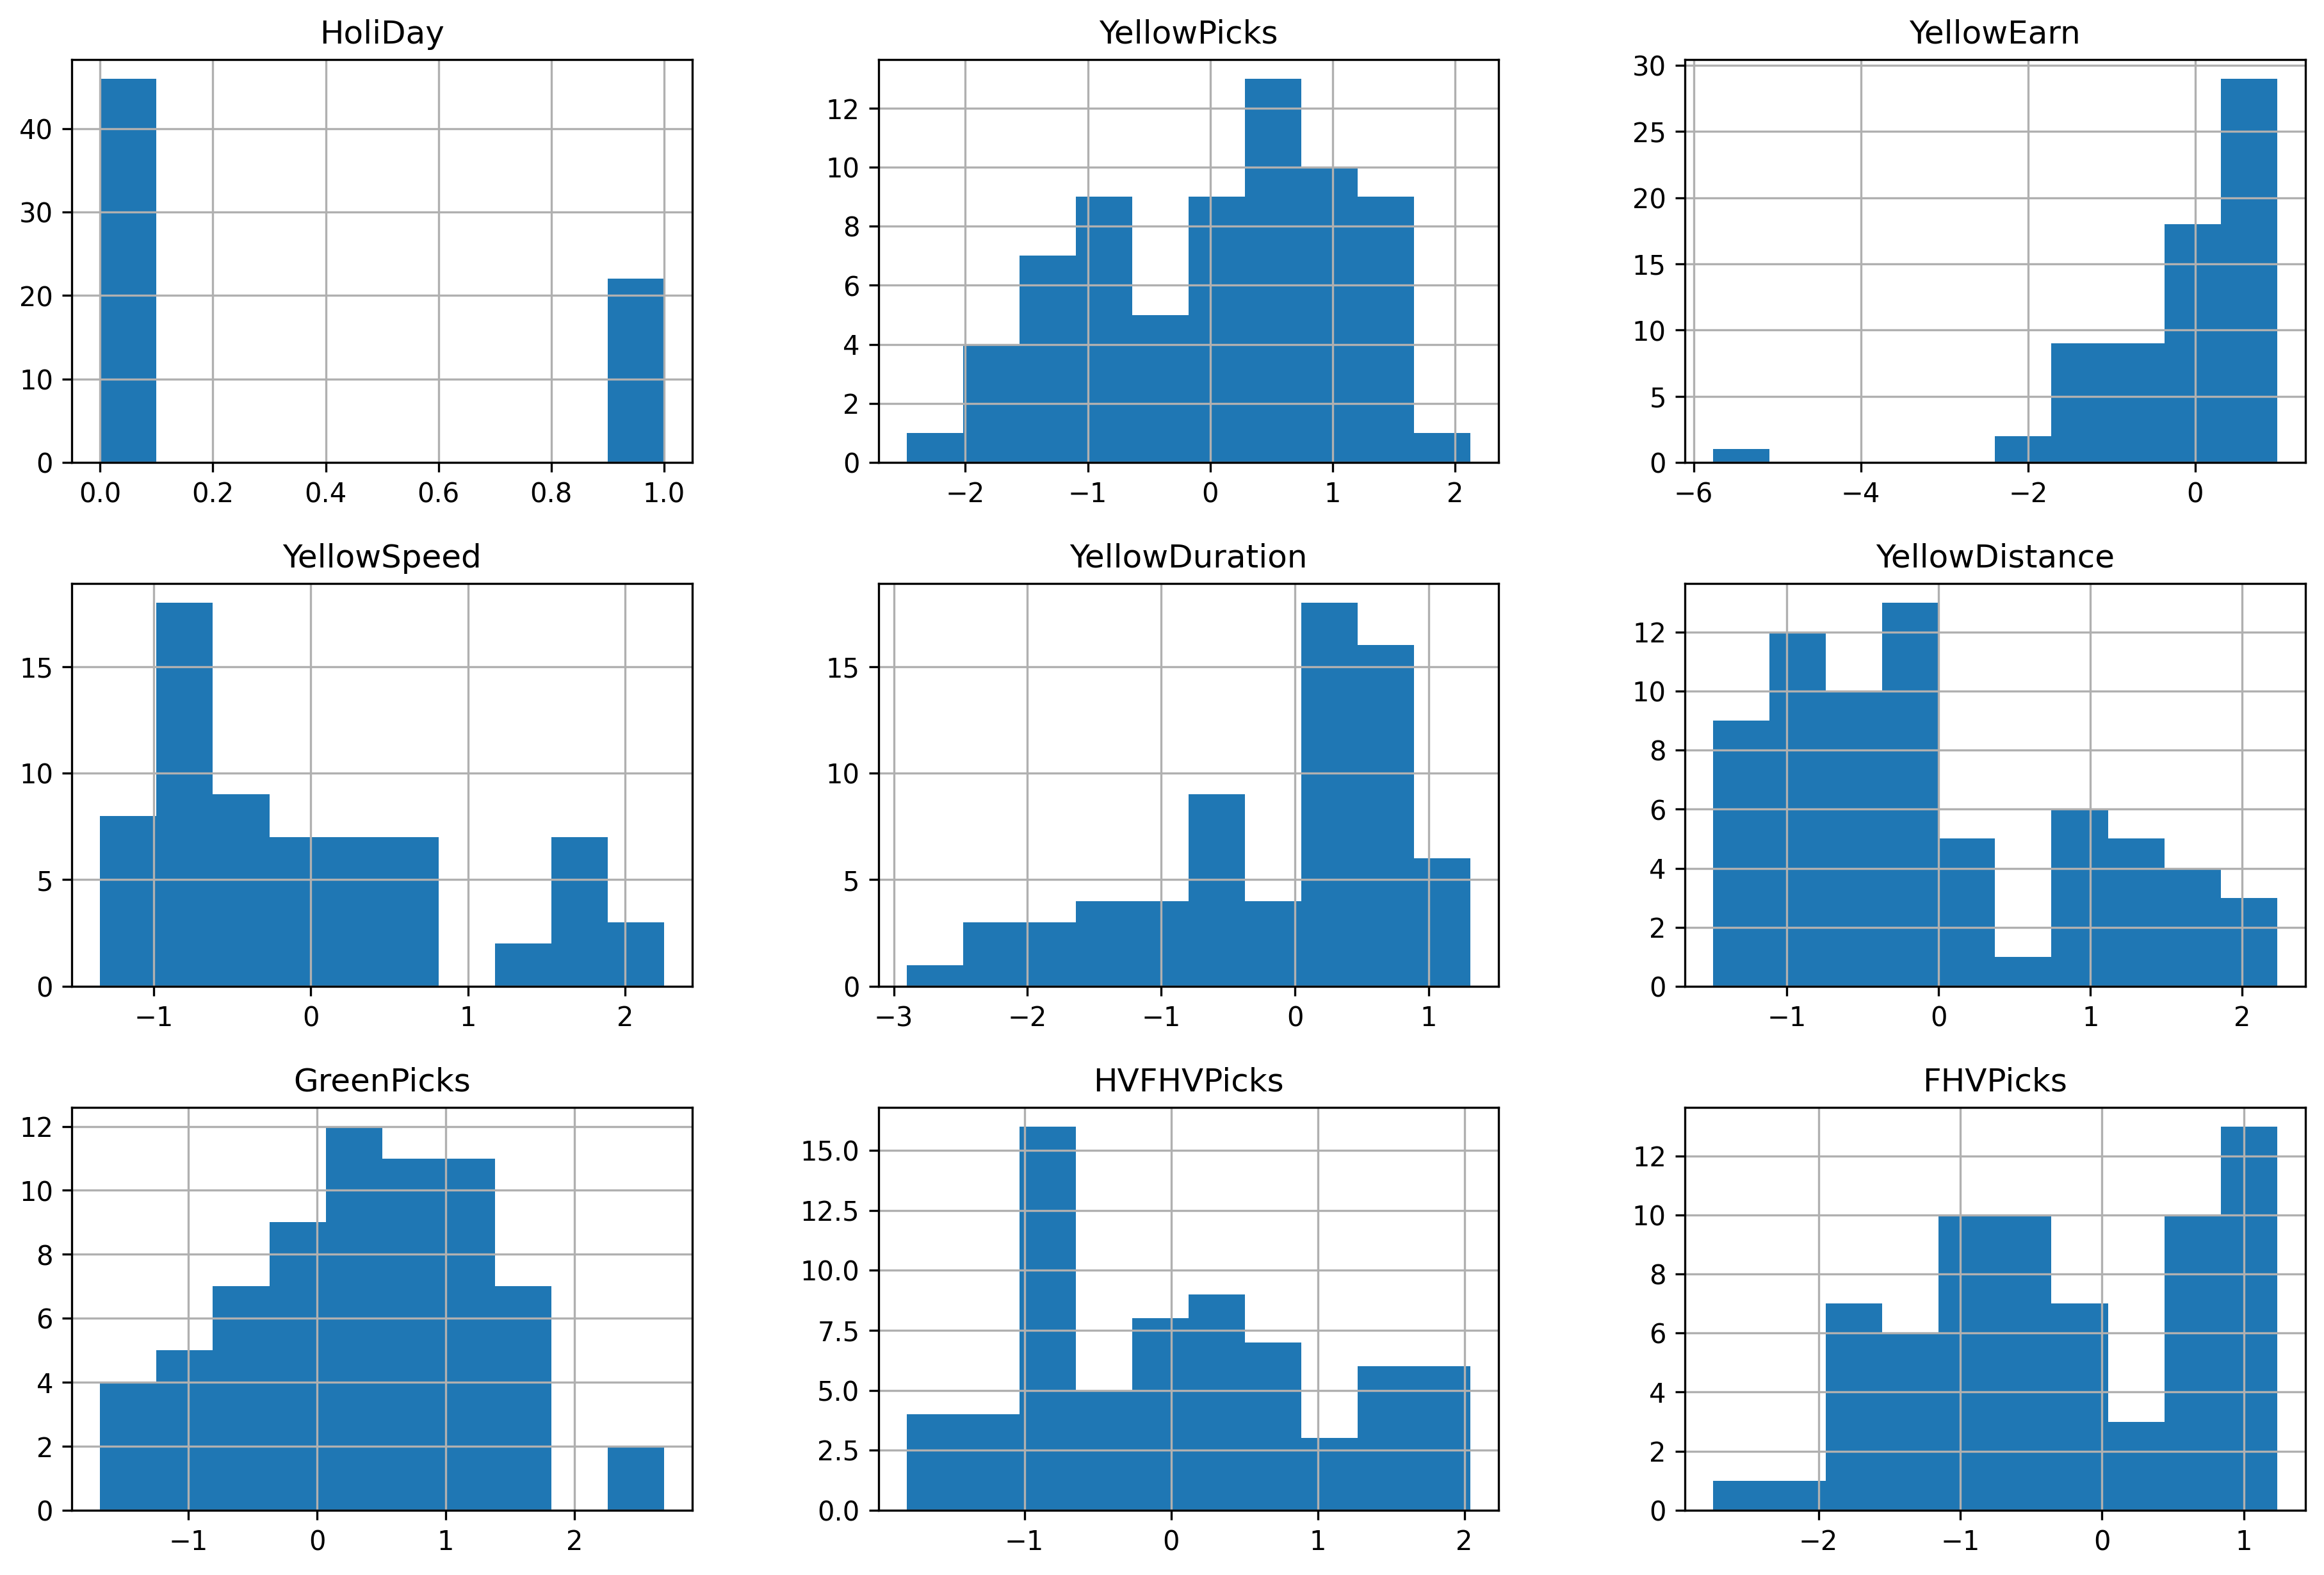

In [72]:
lm_data_weekend.hist()


###With Weekend

In [73]:
## Reference:  https://www.codenong.com/aa2e3f5a66fe9e2895fa/
## Modified Function to avoid infinity loop, takes various input types...

def step_aic(model, exog, endog, **kwargs):
    """
    This select the best exogenous variables with AIC
    Both exog and endog values can be either str or list.
    (Endog list is for the Binomial family.)

    Note: This adopt only "forward" selection

    Args:
        model: model from statsmodels.formula.api
        exog (str or list): exogenous variables
        endog (str or list): endogenous variables
        kwargs: extra keyword argments for model (e.g., data, family)

    Returns:
        model: a model that seems to have the smallest AIC
    """
    exog = exog.split("+")
    endog = endog.split("+")
    # exog, endog change value
    exog = np.r_[[exog]].flatten()
    endog = np.r_[[endog]].flatten()
    remaining = set(exog)
    selected = []  # Selected

    # AIC Calculation
    formula_head = ' + '.join(endog) + ' ~ '
    formula = formula_head + '1'
    aic = model(formula=formula, **kwargs).fit().aic
    print('AIC: {}, formula: {}'.format(np.round(aic, 3), formula))

    current_score, best_new_score = np.ones(2) * aic

    # Until get best score, looping
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:

            # Calculate AIC and print
            formula_tail = ' + '.join(selected + [candidate])
            formula = formula_head + formula_tail
            aic = model(formula=formula, **kwargs).fit().aic
            print('AIC: {}, formula: {}'.format(np.round(aic, 3), formula))

            scores_with_candidates.append((aic, candidate))

        # get AIC best Candidate
        scores_with_candidates.sort()
        scores_with_candidates.reverse()
        best_new_score, best_candidate = scores_with_candidates.pop()

        # Assign New best Score
        if best_new_score <= current_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score

    formula = formula_head + ' + '.join(selected)
    print('The best formula: {}'.format(formula))
    return model(formula, **kwargs).fit()

### With Weekend

In [74]:
import statsmodels.api as sm
anova_lm = sm.stats.anova_lm

In [75]:
## Use Full Additive Model



#lm = ols("HVFHVPicks ~ YellowPicks", data=lm_data_weekend).fit()
lm_total = ols("HVFHVPicks ~ HoliDay+YellowPicks+GreenPicks+YellowEarn+YellowSpeed+YellowDuration+YellowDistance+FHVPicks", data=lm_data_weekend).fit()
#lm2 = ols("HVFHVPicks ~ YellowPicks*GreenPicks*YellowEarn*YellowSpeed*YellowDuration*YellowDistance", data=lm_data_weekend).fit()
print(lm_total.summary())

                            OLS Regression Results                            
Dep. Variable:             HVFHVPicks   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     34.18
Date:                Sun, 15 Aug 2021   Prob (F-statistic):           2.09e-19
Time:                        00:39:36   Log-Likelihood:                -39.380
No. Observations:                  68   AIC:                             96.76
Df Residuals:                      59   BIC:                             116.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.4199      0.118     -3.

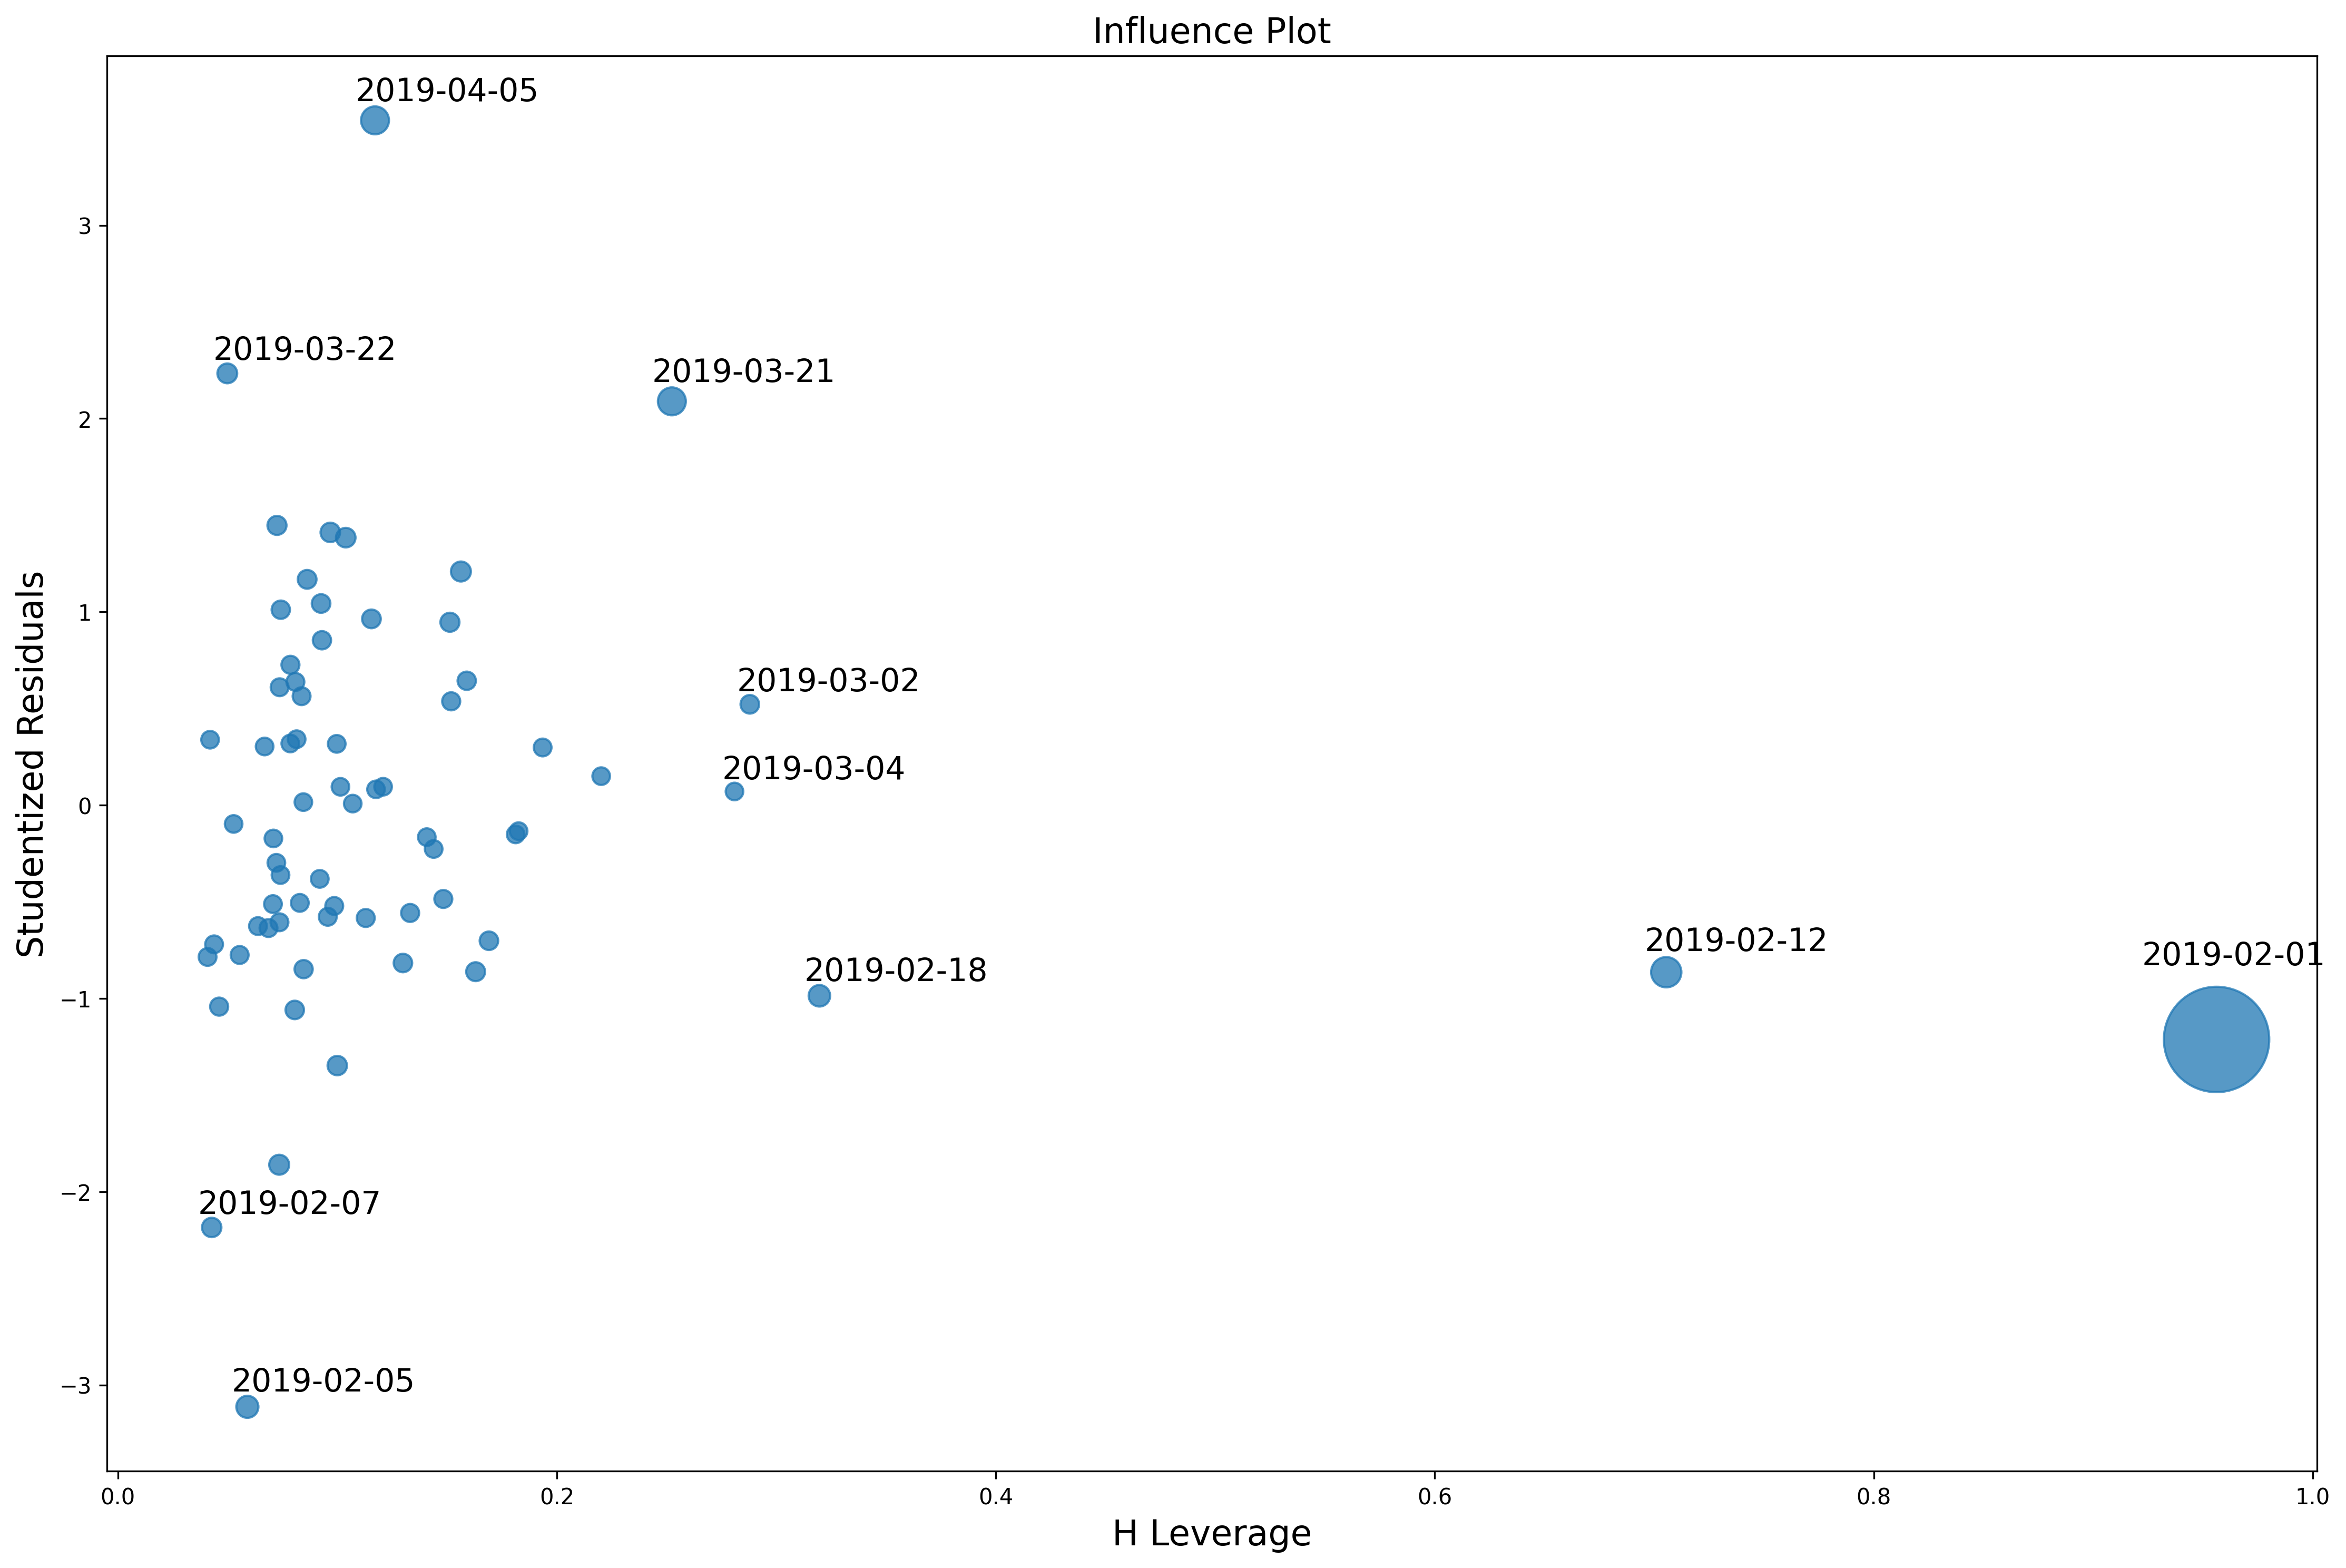

In [76]:
fig = sm.graphics.influence_plot(lm_total, criterion="cooks")
fig.tight_layout(pad=1.0)
fig.savefig("../plots/InfluencePlot.png")

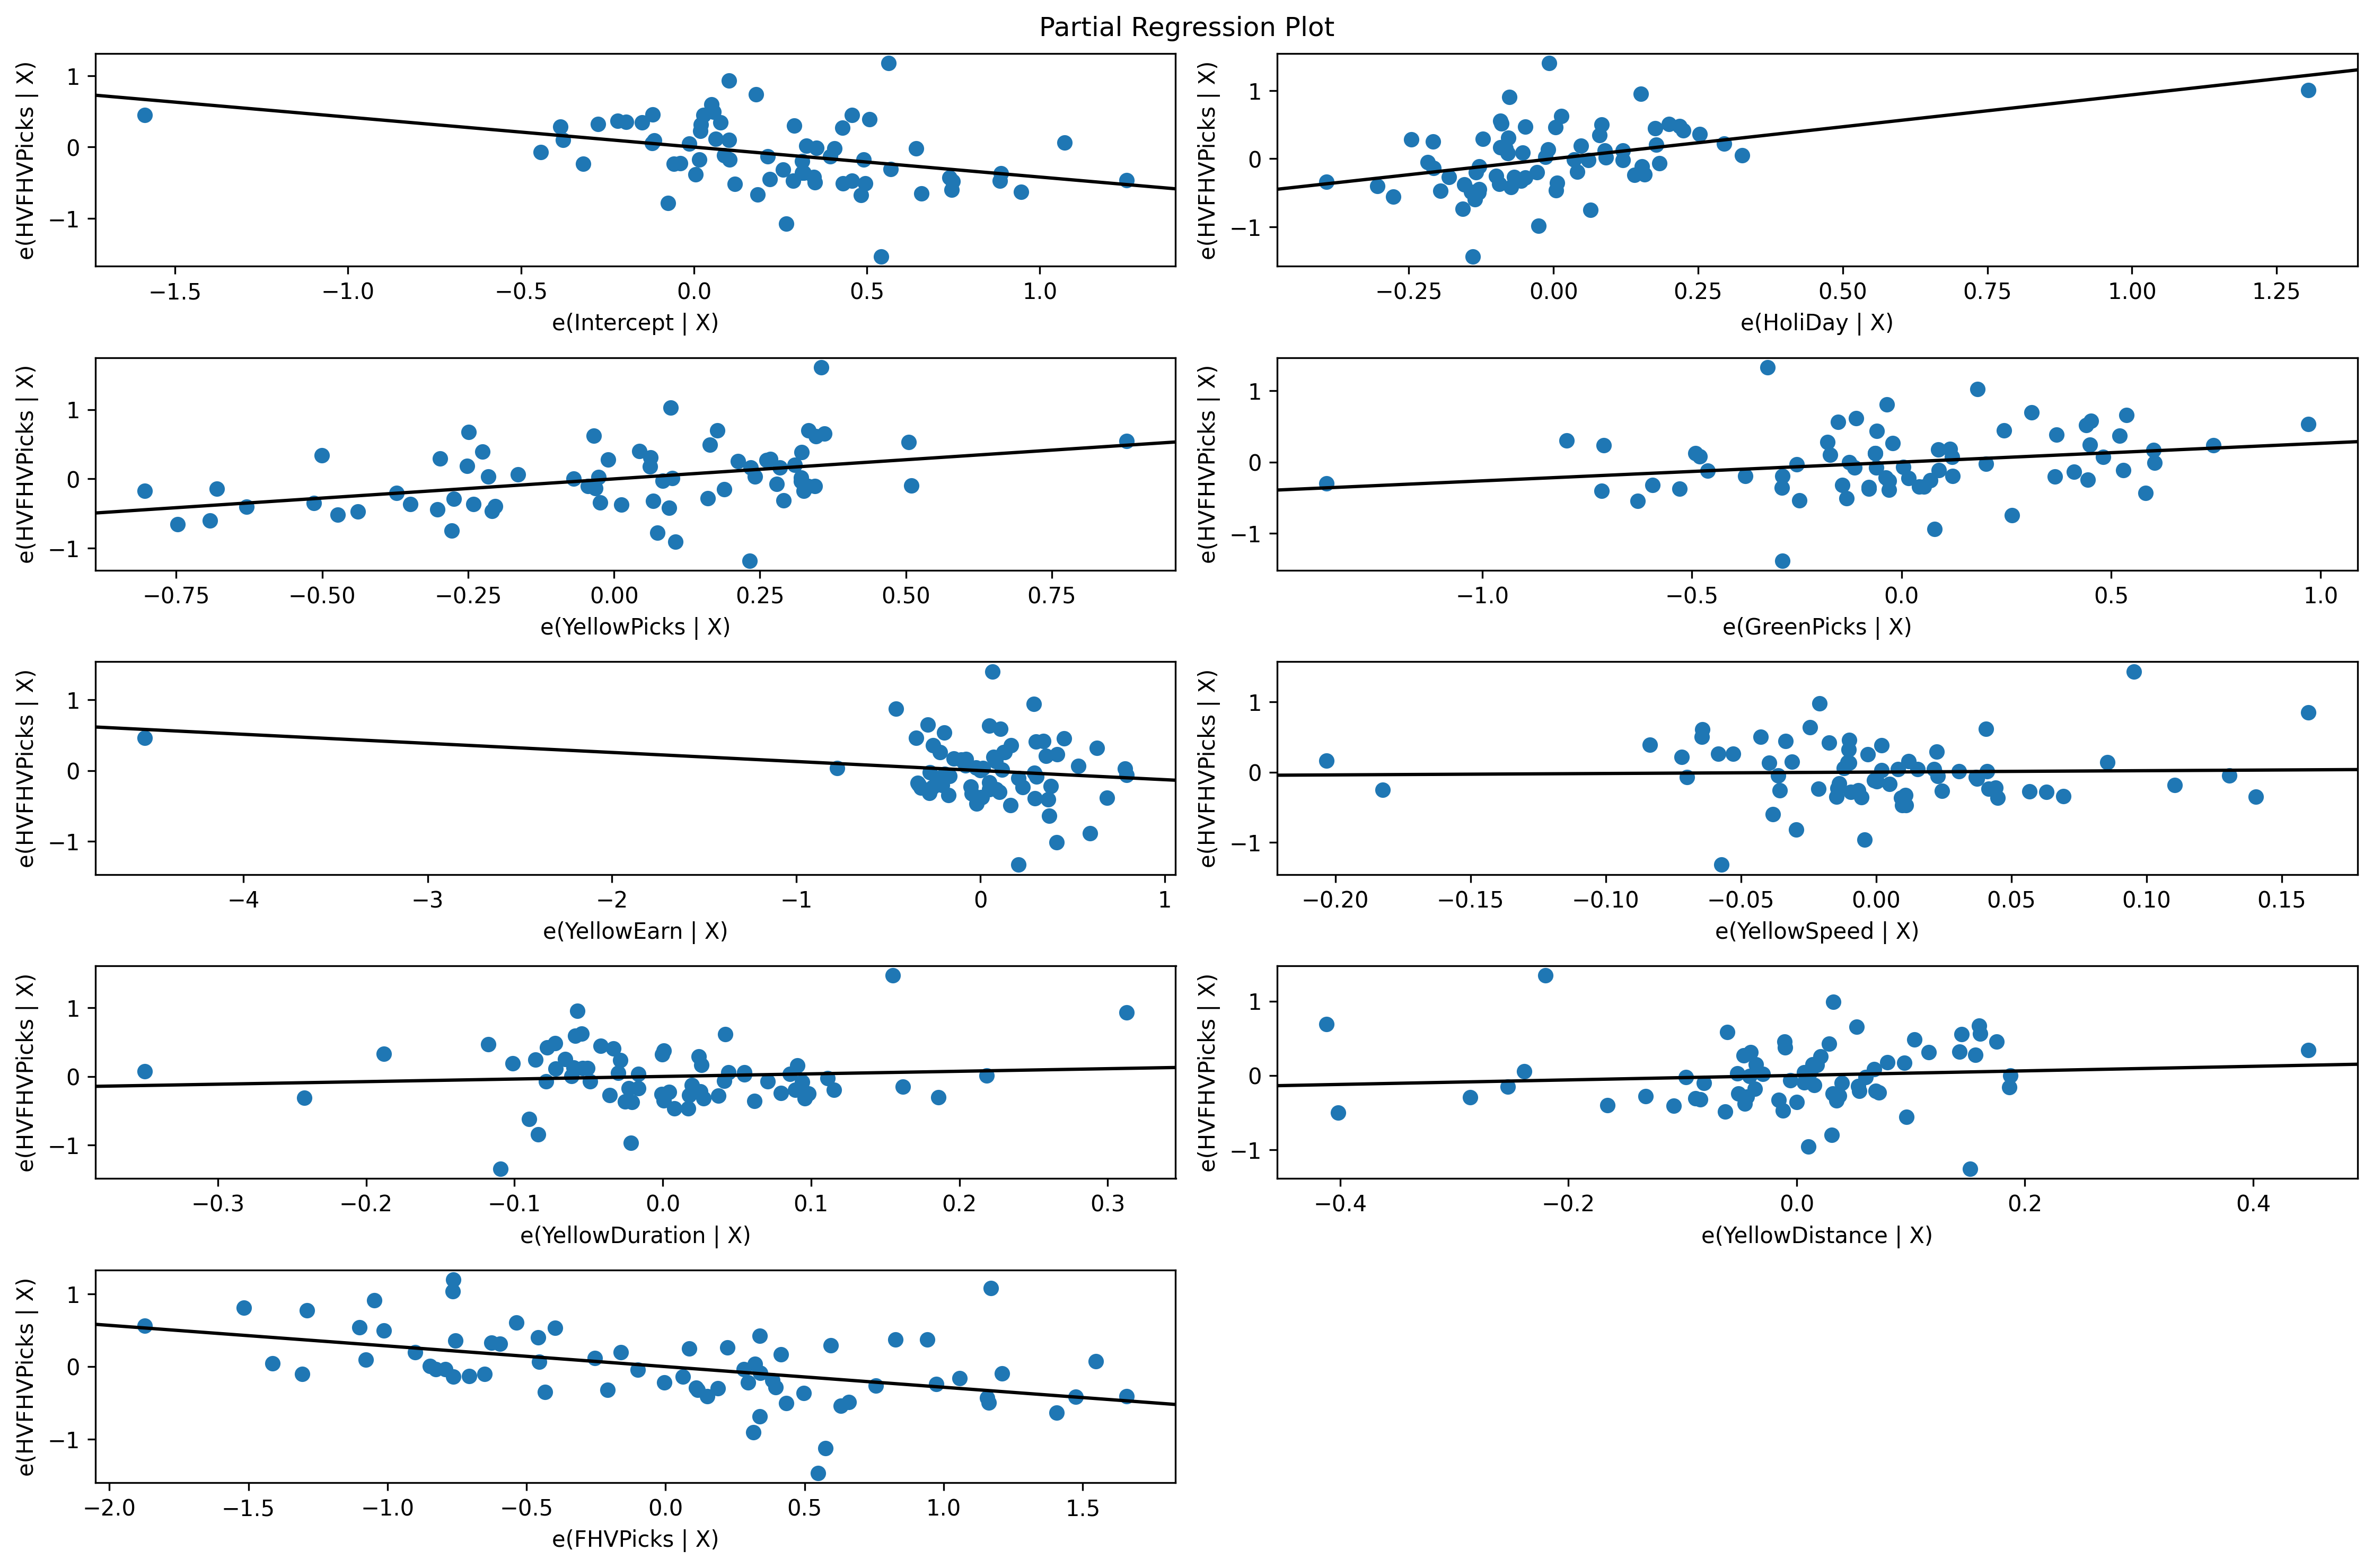

In [77]:
fig = sm.graphics.plot_partregress_grid(lm_total)
fig.tight_layout(pad=1.0)


- With 2019-02-01, 2019-02-12 an outlier, Remove it


In [78]:
# Drop 2019-02-01 Outlier
lm_data_weekend.drop("2019-02-01", axis=0, inplace=True)

In [79]:
# Fit General Additive Model

lm_additive = ols("HVFHVPicks ~ HoliDay+YellowPicks+GreenPicks+YellowEarn+YellowSpeed+YellowDuration+YellowDistance", data=lm_data_weekend).fit()

print(lm_additive.summary())

                            OLS Regression Results                            
Dep. Variable:             HVFHVPicks   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     28.36
Date:                Sun, 15 Aug 2021   Prob (F-statistic):           1.16e-16
Time:                        00:39:38   Log-Likelihood:                -47.059
No. Observations:                  67   AIC:                             110.1
Df Residuals:                      59   BIC:                             127.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.1182      0.172     -0.

In [80]:
## StepWise Get Lowest AIC value, Remove Duration, Distance, Earn Doesn't have significant effect on model effectiveness

In [81]:
step_aic(ols,"HoliDay+YellowPicks+GreenPicks+YellowEarn+YellowSpeed+YellowDuration+YellowDistance", 'HVFHVPicks', data=lm_data_weekend)

AIC: 194.849, formula: HVFHVPicks ~ 1
AIC: 181.503, formula: HVFHVPicks ~ YellowPicks
AIC: 196.488, formula: HVFHVPicks ~ YellowSpeed
AIC: 174.014, formula: HVFHVPicks ~ HoliDay
AIC: 196.049, formula: HVFHVPicks ~ YellowDuration
AIC: 196.148, formula: HVFHVPicks ~ YellowEarn
AIC: 190.285, formula: HVFHVPicks ~ YellowDistance
AIC: 185.387, formula: HVFHVPicks ~ GreenPicks
AIC: 115.963, formula: HVFHVPicks ~ HoliDay + YellowPicks
AIC: 146.043, formula: HVFHVPicks ~ HoliDay + YellowSpeed
AIC: 135.647, formula: HVFHVPicks ~ HoliDay + YellowDuration
AIC: 153.68, formula: HVFHVPicks ~ HoliDay + YellowEarn
AIC: 171.248, formula: HVFHVPicks ~ HoliDay + YellowDistance
AIC: 131.829, formula: HVFHVPicks ~ HoliDay + GreenPicks
AIC: 114.219, formula: HVFHVPicks ~ HoliDay + YellowPicks + YellowSpeed
AIC: 117.81, formula: HVFHVPicks ~ HoliDay + YellowPicks + YellowDuration
AIC: 117.817, formula: HVFHVPicks ~ HoliDay + YellowPicks + YellowEarn
AIC: 106.176, formula: HVFHVPicks ~ HoliDay + YellowPicks 

### BY AIC StepWise Model Selection The Best Model We get So far is:
HVFHVPicks ~ HoliDay + YellowPicks + YellowDistance + GreenPicks

In [82]:
lm_best = ols("HVFHVPicks ~ HoliDay+YellowPicks+YellowDistance", data=lm_data_weekend).fit()
lm_best.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             HVFHVPicks   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     65.28
Date:                Sun, 15 Aug 2021   Prob (F-statistic):           2.62e-19
Time:                        00:39:38   Log-Likelihood:                -49.088
No. Observations:                  67   AIC:                             106.2
Df Residuals:                      63   BIC:                             115.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.2681      0.106     -2.536      0.014      -0.479      -0.057
HoliDay            0.9226      0.246      3.749      0.000       0.431       1.414
YellowPicks        0.8619      0.083     10.413      0.000       0.697       1.027
YellowDistance     0.4806      0.138      3.481      0.001       0.205       0.756
==============================================================================
Omnibus:                        2.980   Durbin-Watson:                   1.146
Prob(Omnibus):                  0.225   Jarque-Bera (JB):                2.701
Skew:                          -0.053   Prob(JB):                        0.259
Kurtosis:                       3.978   Cond. No.                         5.89
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [83]:
## ANOVA test selected Model VS Total Model
print(anova_lm(lm_best,lm_total))
print("\n Found Significant model improvement")

   df_resid        ssr  df_diff   ss_diff         F    Pr(>F)
0      63.0  16.981470      0.0       NaN       NaN       NaN
1      59.0  12.677985      4.0  4.303485  5.006821  0.001527

 Found Significant model improvement


In [84]:
### Test Interaction

In [85]:
# Test interaction
lm_1 = ols("HVFHVPicks ~ HoliDay+YellowPicks+GreenPicks*YellowDistance", data=lm_data_weekend).fit()
lm_2 = ols("HVFHVPicks ~ HoliDay+YellowPicks*GreenPicks+YellowDistance", data=lm_data_weekend).fit()
lm_3 = ols("HVFHVPicks ~ HoliDay+YellowPicks*YellowDistance+GreenPicks", data=lm_data_weekend).fit()
lm_4 = ols("HVFHVPicks ~ HoliDay*YellowPicks+GreenPicks+YellowDistance", data=lm_data_weekend).fit()
lm_5 = ols("HVFHVPicks ~ HoliDay*YellowPicks*GreenPicks+YellowDistance", data=lm_data_weekend).fit()
lm_6 = ols("HVFHVPicks ~ HoliDay*YellowPicks*GreenPicks*YellowDistance", data=lm_data_weekend).fit()
print(lm_6.summary())
#sm.stats.anova_lm(lm,lm2)

                            OLS Regression Results                            
Dep. Variable:             HVFHVPicks   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     15.76
Date:                Sun, 15 Aug 2021   Prob (F-statistic):           3.75e-14
Time:                        00:39:38   Log-Likelihood:                -38.496
No. Observations:                  67   AIC:                             109.0
Df Residuals:                      51   BIC:                             144.3
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [86]:
print(anova_lm(lm_best,lm_1))
print(anova_lm(lm_best,lm_2))
print(anova_lm(lm_best,lm_3))
print(anova_lm(lm_best,lm_4))
print(anova_lm(lm_best,lm_5))
print(anova_lm(lm_best,lm_6))
print("\n## It Can be Seen that The interaction is not significant in our model, so stick with additive model")

   df_resid        ssr  df_diff   ss_diff         F    Pr(>F)
0      63.0  16.981470      0.0       NaN       NaN       NaN
1      61.0  16.546044      2.0  0.435426  0.802639  0.452821
   df_resid        ssr  df_diff   ss_diff         F    Pr(>F)
0      63.0  16.981470      0.0       NaN       NaN       NaN
1      61.0  16.328065      2.0  0.653405  1.220527  0.302178
   df_resid        ssr  df_diff   ss_diff         F    Pr(>F)
0      63.0  16.981470      0.0       NaN       NaN       NaN
1      61.0  16.672995      2.0  0.308475  0.564295  0.571701
   df_resid        ssr  df_diff   ss_diff         F    Pr(>F)
0      63.0  16.981470      0.0       NaN       NaN       NaN
1      61.0  16.772347      2.0  0.209123  0.380284  0.685277
   df_resid        ssr  df_diff   ss_diff         F    Pr(>F)
0      63.0  16.981470      0.0       NaN       NaN       NaN
1      58.0  15.119101      5.0  1.862369  1.428887  0.227546
   df_resid        ssr  df_diff   ss_diff         F    Pr(>F)
0      6

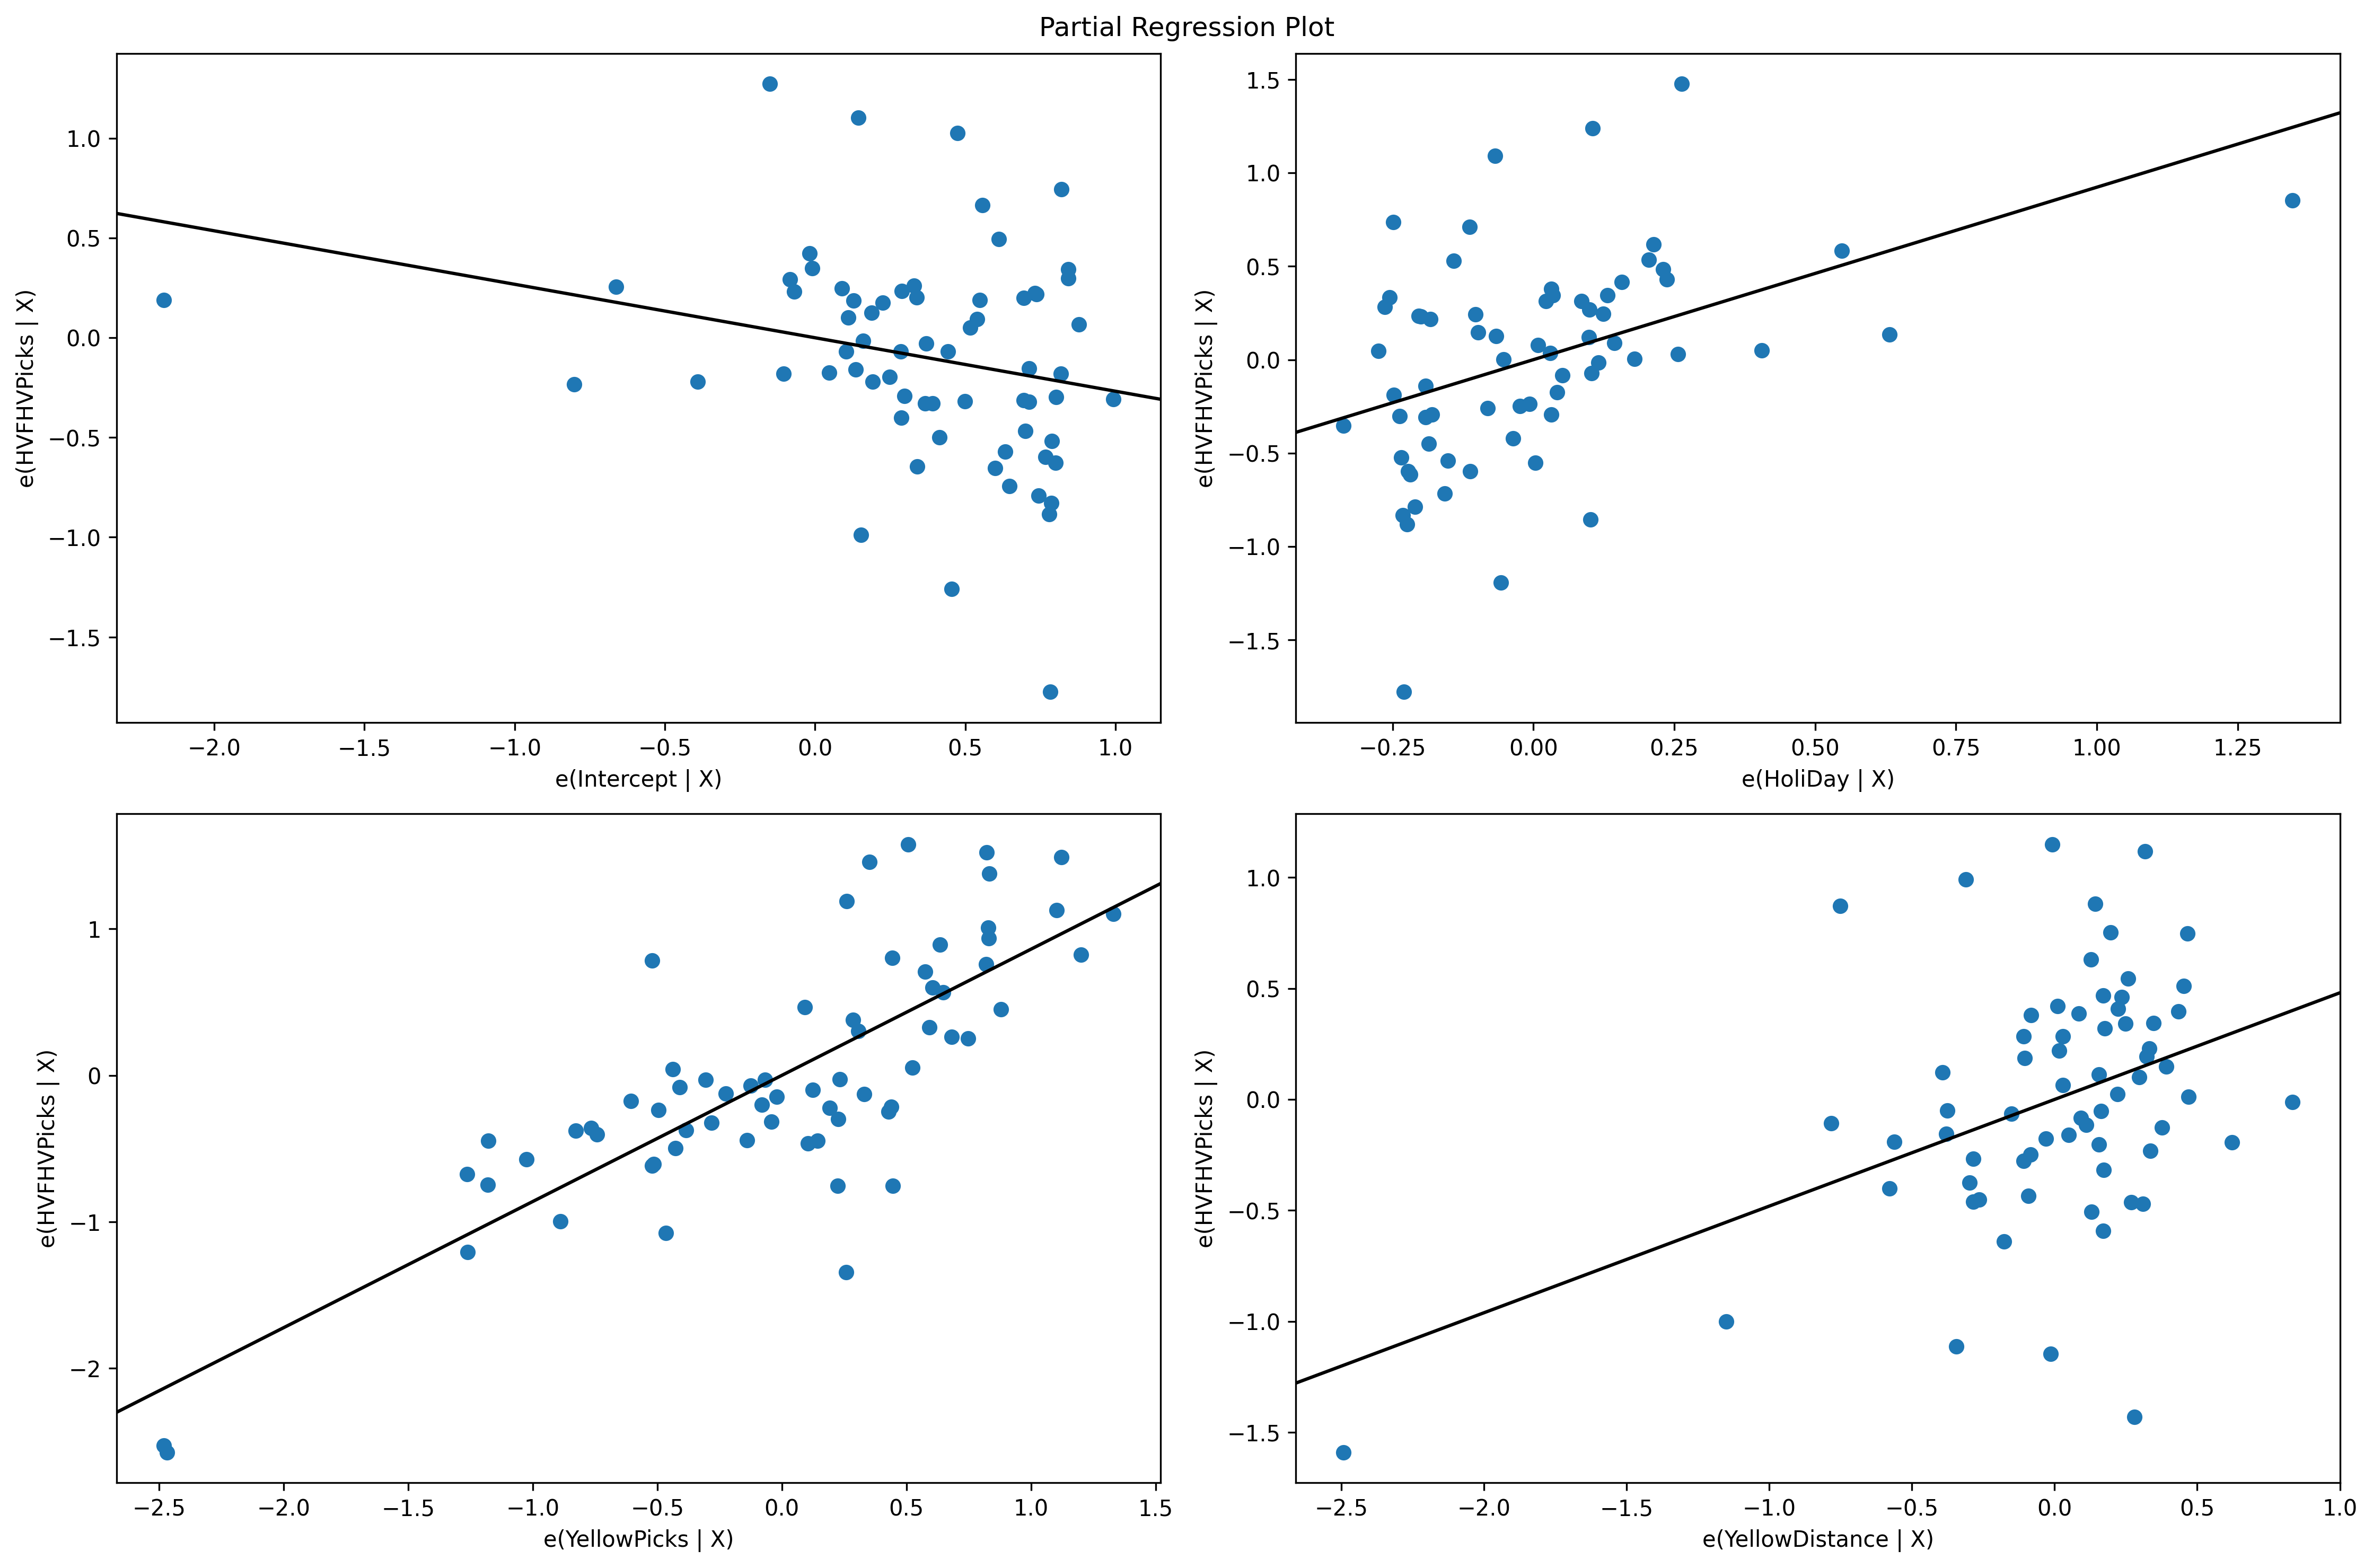

In [87]:
# General View To see problems
fig = sm.graphics.plot_partregress_grid(lm_best)
fig.tight_layout(pad=1.0)


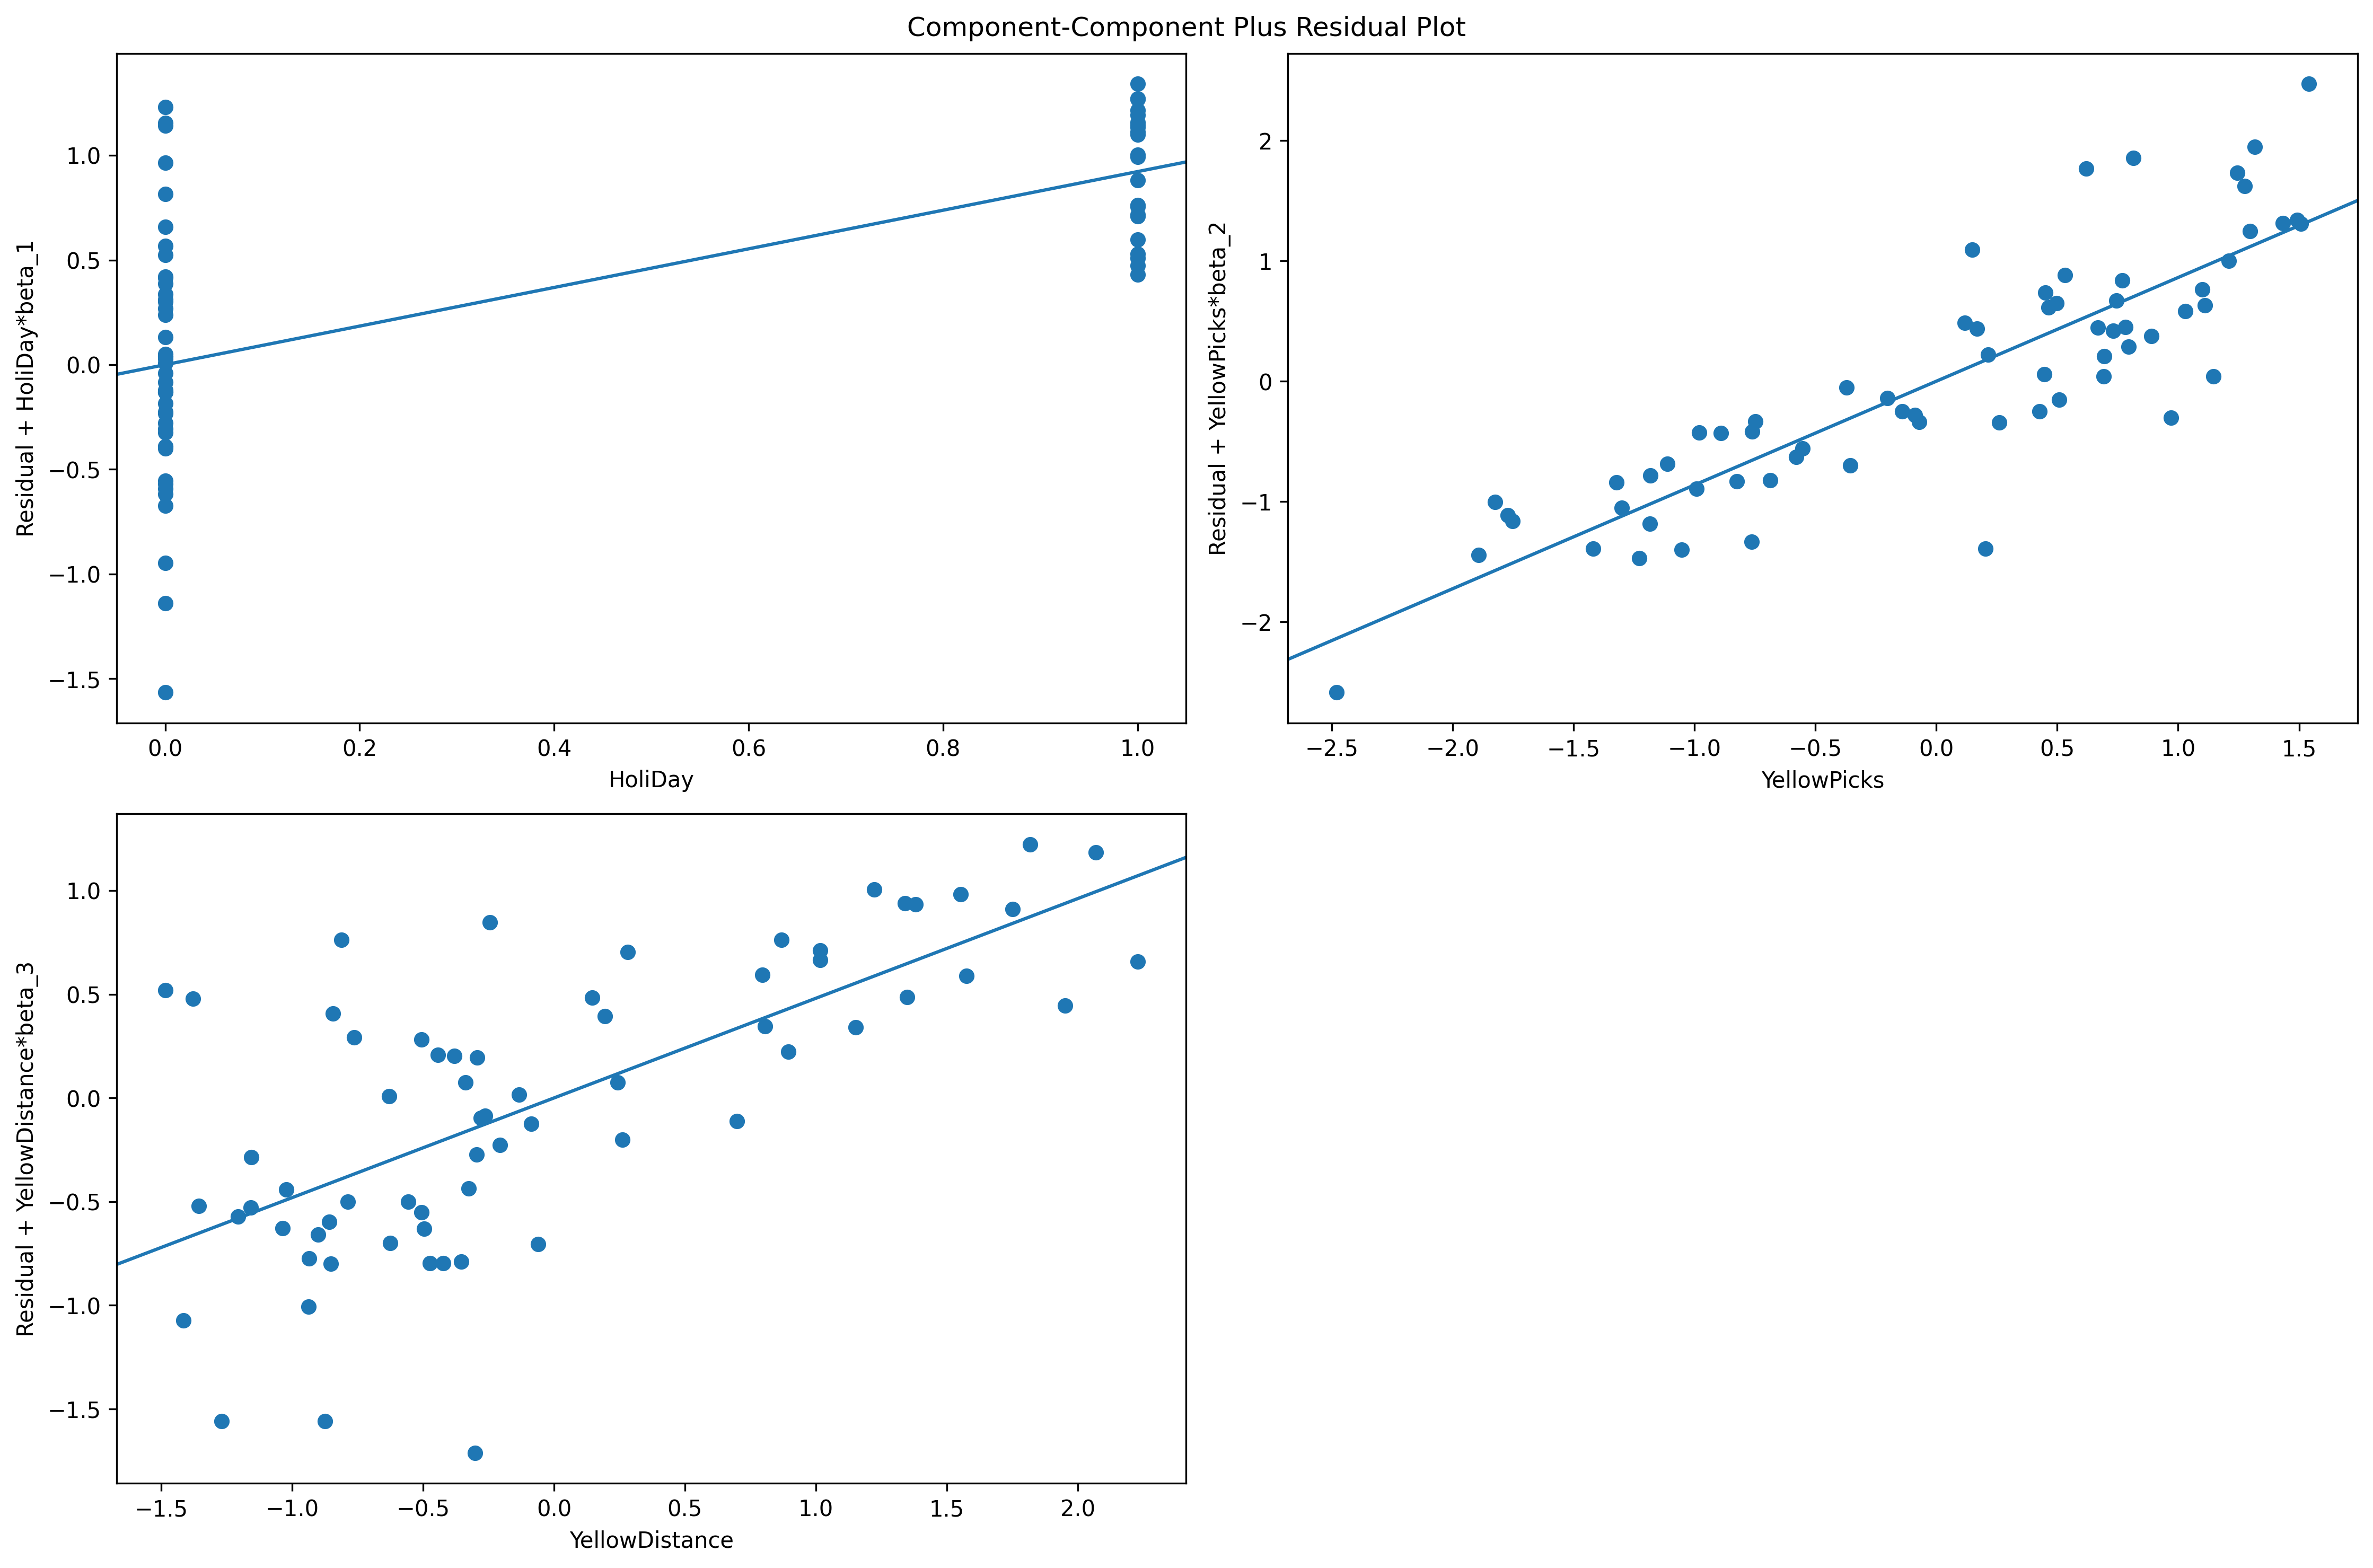

In [88]:
## Y = Selected* + Bi*Xi


fig = sm.graphics.plot_ccpr_grid(lm_best)
fig.tight_layout(pad=1.0)
fig.savefig("../plots/CCPR.png")

In [89]:
from statsmodels.tools.eval_measures import rmse

# fit your model which you have already done

# now generate predictions
ypred = lm_best.predict(lm_data_weekend.drop("HVFHVPicks", axis=1))

# calc rmse
rmse = rmse(lm_data_weekend["HVFHVPicks"], ypred)
rmse

0.5034429276003803

## Exclude Special Days (Weather, Holiday)

As we Remove the Holidays and extreme weather, it is noticable that the performance drops with best additive model only has R value 0.57




In [90]:
lm_data_week = pd.read_parquet("../preprocessed_data/lm_data_weekend.parquet")

lm_data_week.iloc[:,1:] = StandardScaler().fit_transform(lm_data_week.iloc[:,1:]) ## Standardization
## Drop Holiday and Extreme Weather Day

lm_data_week.index = lm_data_week.index.astype(str)


## Add Snow Days to Data
snow_days = ["2019-03-02", "2019-03-03", "2019-03-04"]

#lm_data_week["Snow"] = lm_data_week.index.isin(snow_days)

lm_data_week.drop("2019-03-02", axis=0, inplace=True)
lm_data_week.drop("2019-03-03", axis=0, inplace=True)
lm_data_week.drop("2019-03-04", axis=0, inplace=True)

# Drop Outlier
lm_data_week.drop("2019-02-01", axis=0, inplace=True)

lm_data_week.drop(lm_data_week[lm_data_week["HoliDay"]==True].index, inplace=True)
lm_Date_removed = lm_data_week
lm_Date_removed

,HoliDay,YellowPicks,YellowEarn,YellowSpeed,YellowDuration,YellowDistance,GreenPicks,HVFHVPicks,FHVPicks
date,,,,,,,,,
2019-02-04,False,-0.762882,-0.344377,0.323449,-0.711870,-0.061431,0.443308,-1.629837,0.487880
2019-02-05,False,0.204009,0.278763,-0.282346,0.072307,-0.301680,0.254786,-1.803542,0.351943
2019-02-06,False,1.146090,0.359016,-0.995387,0.569897,-1.268743,1.514072,-0.838162,0.774667
2019-02-07,False,0.971201,0.649343,-0.890575,0.738384,-0.875582,1.206929,-0.990494,0.755530
2019-02-08,False,1.506810,0.460512,-1.079602,0.809244,-1.206719,2.295168,0.458761,0.923182
...,...,...,...,...,...,...,...,...,...
2019-05-06,False,-1.163221,0.264601,0.044063,-0.050516,-0.071793,-1.704043,-1.228884,0.962894
2019-05-07,False,-0.031608,0.753199,-0.620309,0.697443,-0.507734,-0.964253,-0.979519,0.979785
2019-05-08,False,0.001491,1.229996,-0.723379,1.204481,-0.327289,-0.859930,-1.179434,1.153187


In [91]:
## Use Step AIC to find Best Model

lm_removed_best = step_aic(ols,"HoliDay+YellowPicks+GreenPicks+YellowEarn+YellowSpeed+YellowDuration+YellowDistance", 'HVFHVPicks', data=lm_Date_removed)

AIC: 160.493, formula: HVFHVPicks ~ 1
AIC: 119.74, formula: HVFHVPicks ~ YellowPicks
AIC: 137.766, formula: HVFHVPicks ~ YellowSpeed
AIC: 160.493, formula: HVFHVPicks ~ HoliDay
AIC: 146.048, formula: HVFHVPicks ~ YellowDuration
AIC: 156.57, formula: HVFHVPicks ~ YellowEarn
AIC: 147.476, formula: HVFHVPicks ~ YellowDistance
AIC: 136.509, formula: HVFHVPicks ~ GreenPicks
AIC: 121.409, formula: HVFHVPicks ~ YellowPicks + YellowSpeed
AIC: 119.74, formula: HVFHVPicks ~ YellowPicks + HoliDay
AIC: 121.575, formula: HVFHVPicks ~ YellowPicks + YellowDuration
AIC: 119.545, formula: HVFHVPicks ~ YellowPicks + YellowEarn
AIC: 121.634, formula: HVFHVPicks ~ YellowPicks + YellowDistance
AIC: 119.382, formula: HVFHVPicks ~ YellowPicks + GreenPicks
AIC: 121.302, formula: HVFHVPicks ~ YellowPicks + GreenPicks + YellowSpeed
AIC: 119.382, formula: HVFHVPicks ~ YellowPicks + GreenPicks + HoliDay
AIC: 121.263, formula: HVFHVPicks ~ YellowPicks + GreenPicks + YellowDuration
AIC: 120.849, formula: HVFHVPicks

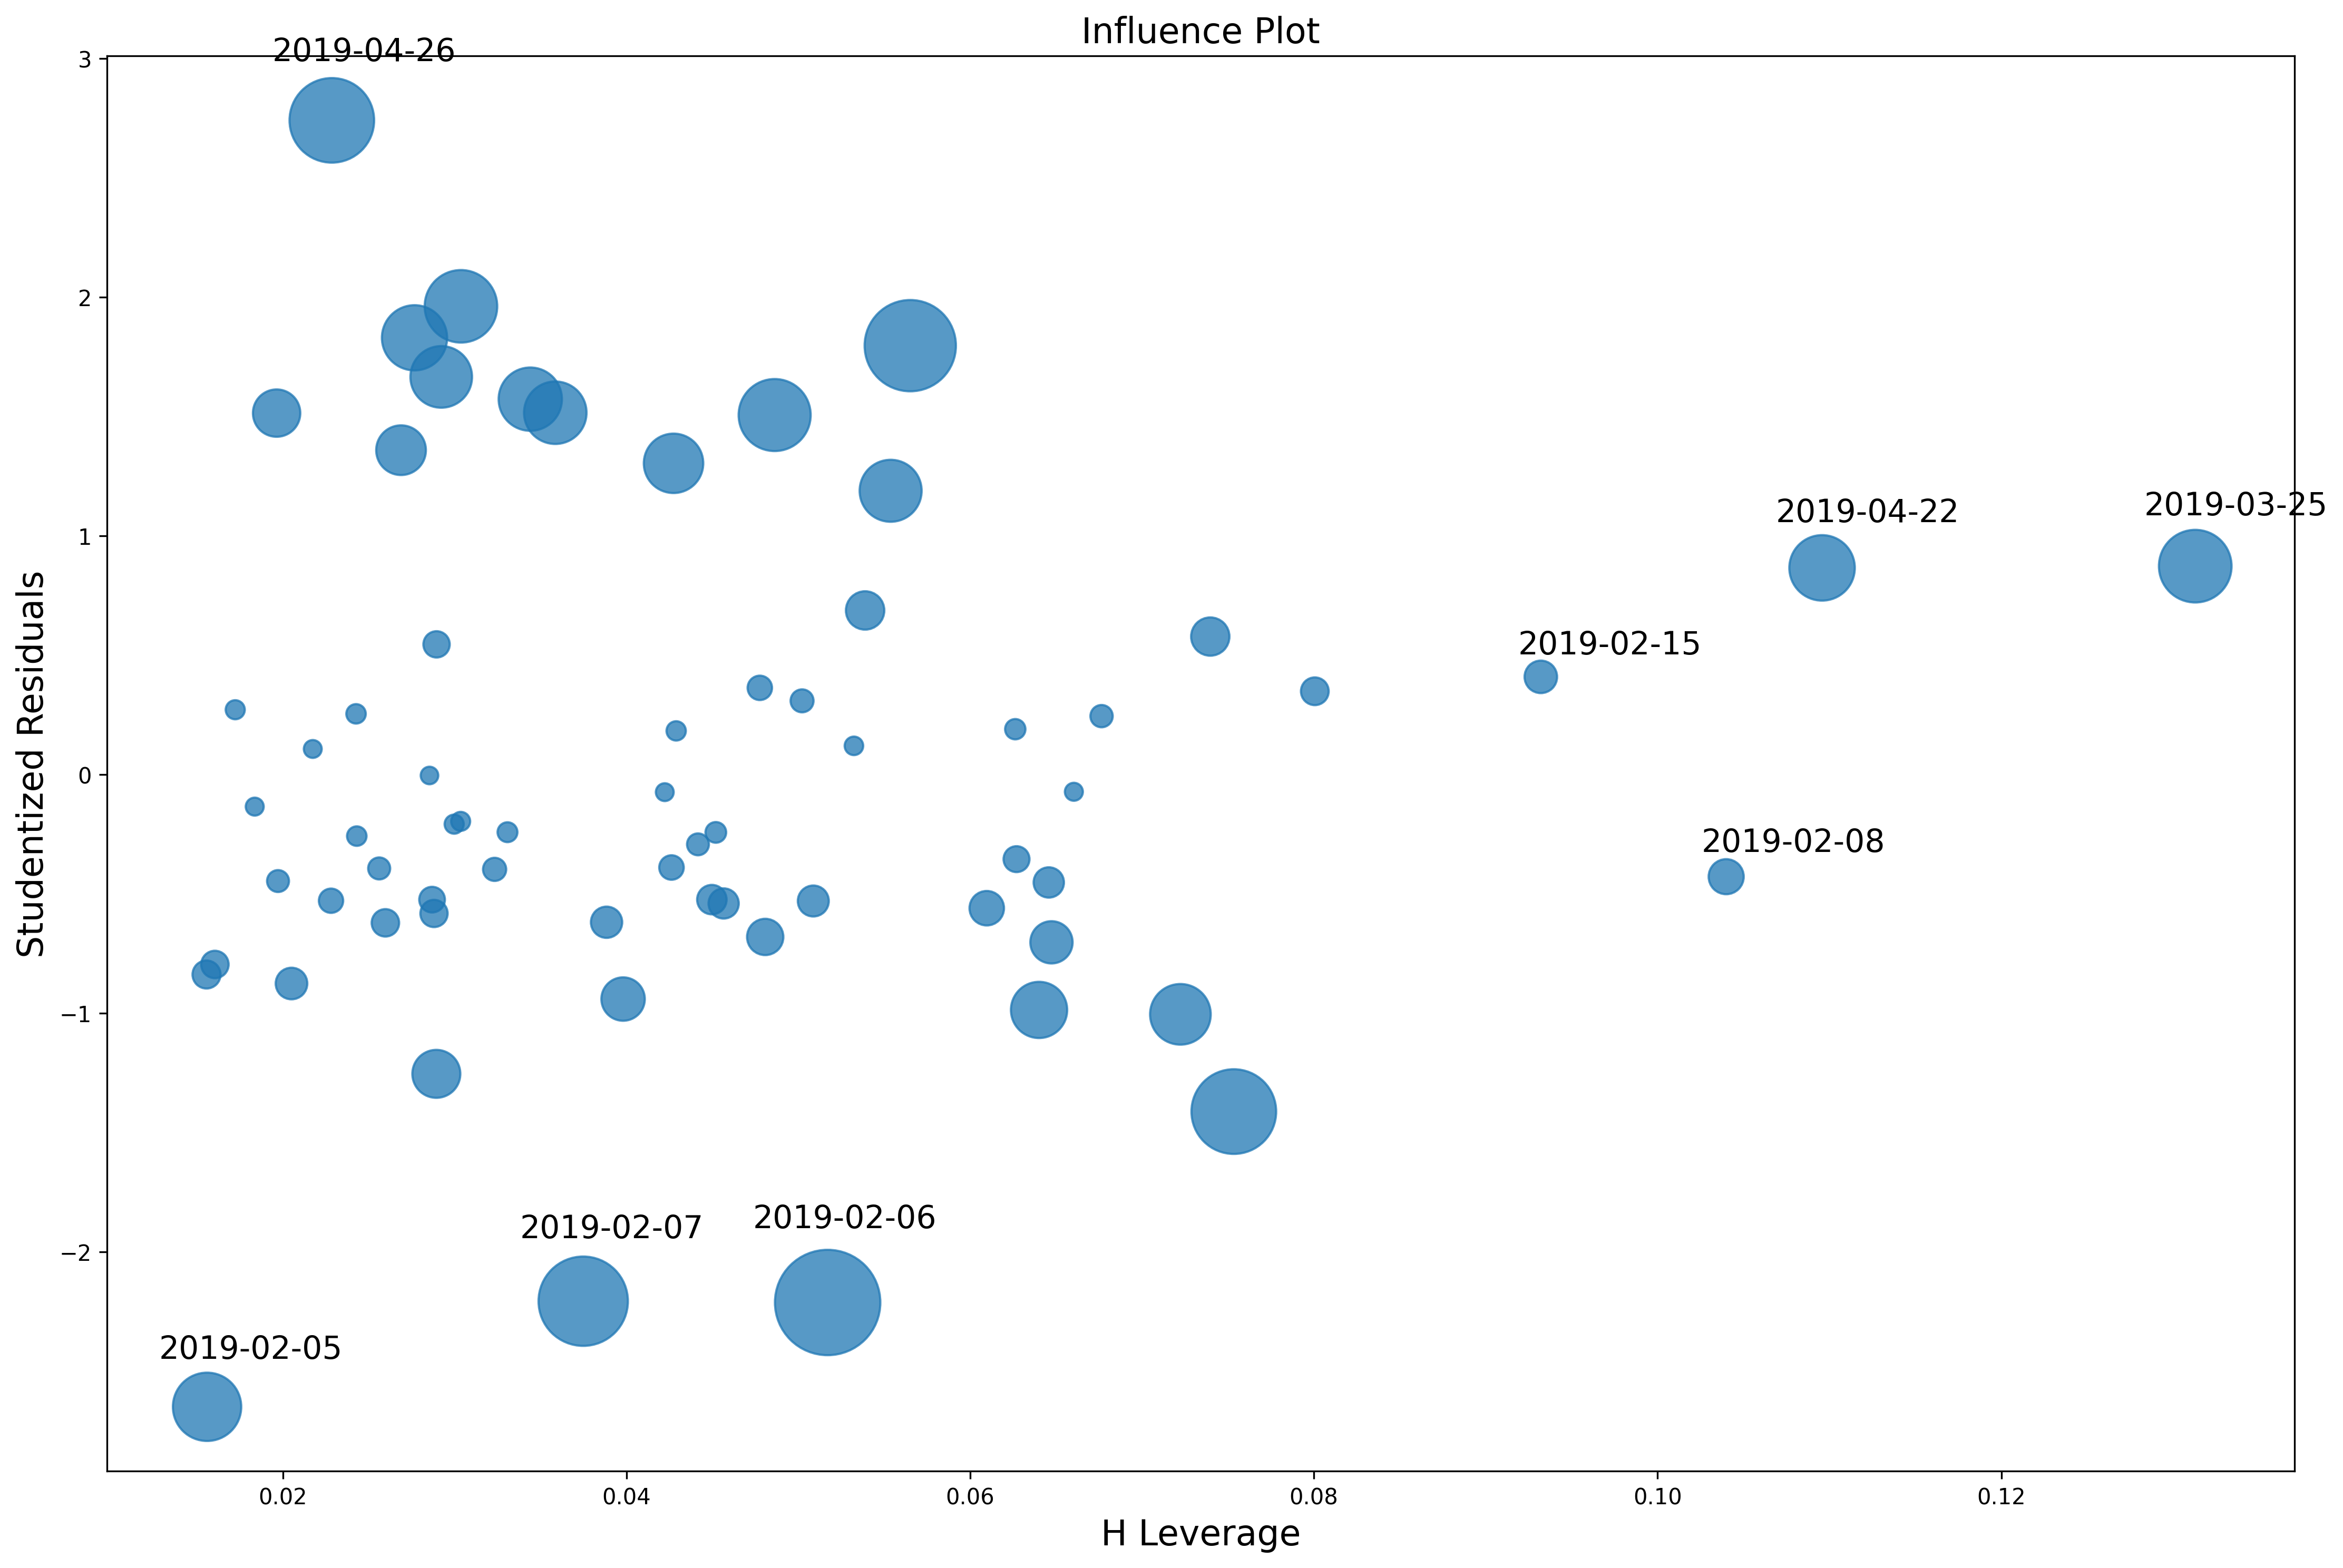

In [92]:
fig = sm.graphics.influence_plot(lm_removed_best, criterion="cooks")
fig.tight_layout(pad=1.0)

In [93]:
#lm_best_removed = ols("HVFHVPicks ~ HoliDay+YellowPicks+GreenPicks", data=lm_Date_removed).fit()

lm_removed_best.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             HVFHVPicks   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     30.74
Date:                Sun, 15 Aug 2021   Prob (F-statistic):           4.39e-10
Time:                        00:39:41   Log-Likelihood:                -56.691
No. Observations:                  67   AIC:                             119.4
Df Residuals:                      64   BIC:                             126.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.5073      0.073     -6.959      0.000      -0.653      -0.362
YellowPicks     0.5477      0.119      4.599      0.000       0.310       0.786
GreenPicks      0.1638      0.108      1.514      0.135      -0.052       0.380
==============================================================================
Omnibus:                        1.390   Durbin-Watson:                   1.143
Prob(Omnibus):                  0.499   Jarque-Bera (JB):                0.797
Skew:                           0.228   Prob(JB):                        0.671
Kurtosis:                       3.277   Cond. No.                         2.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

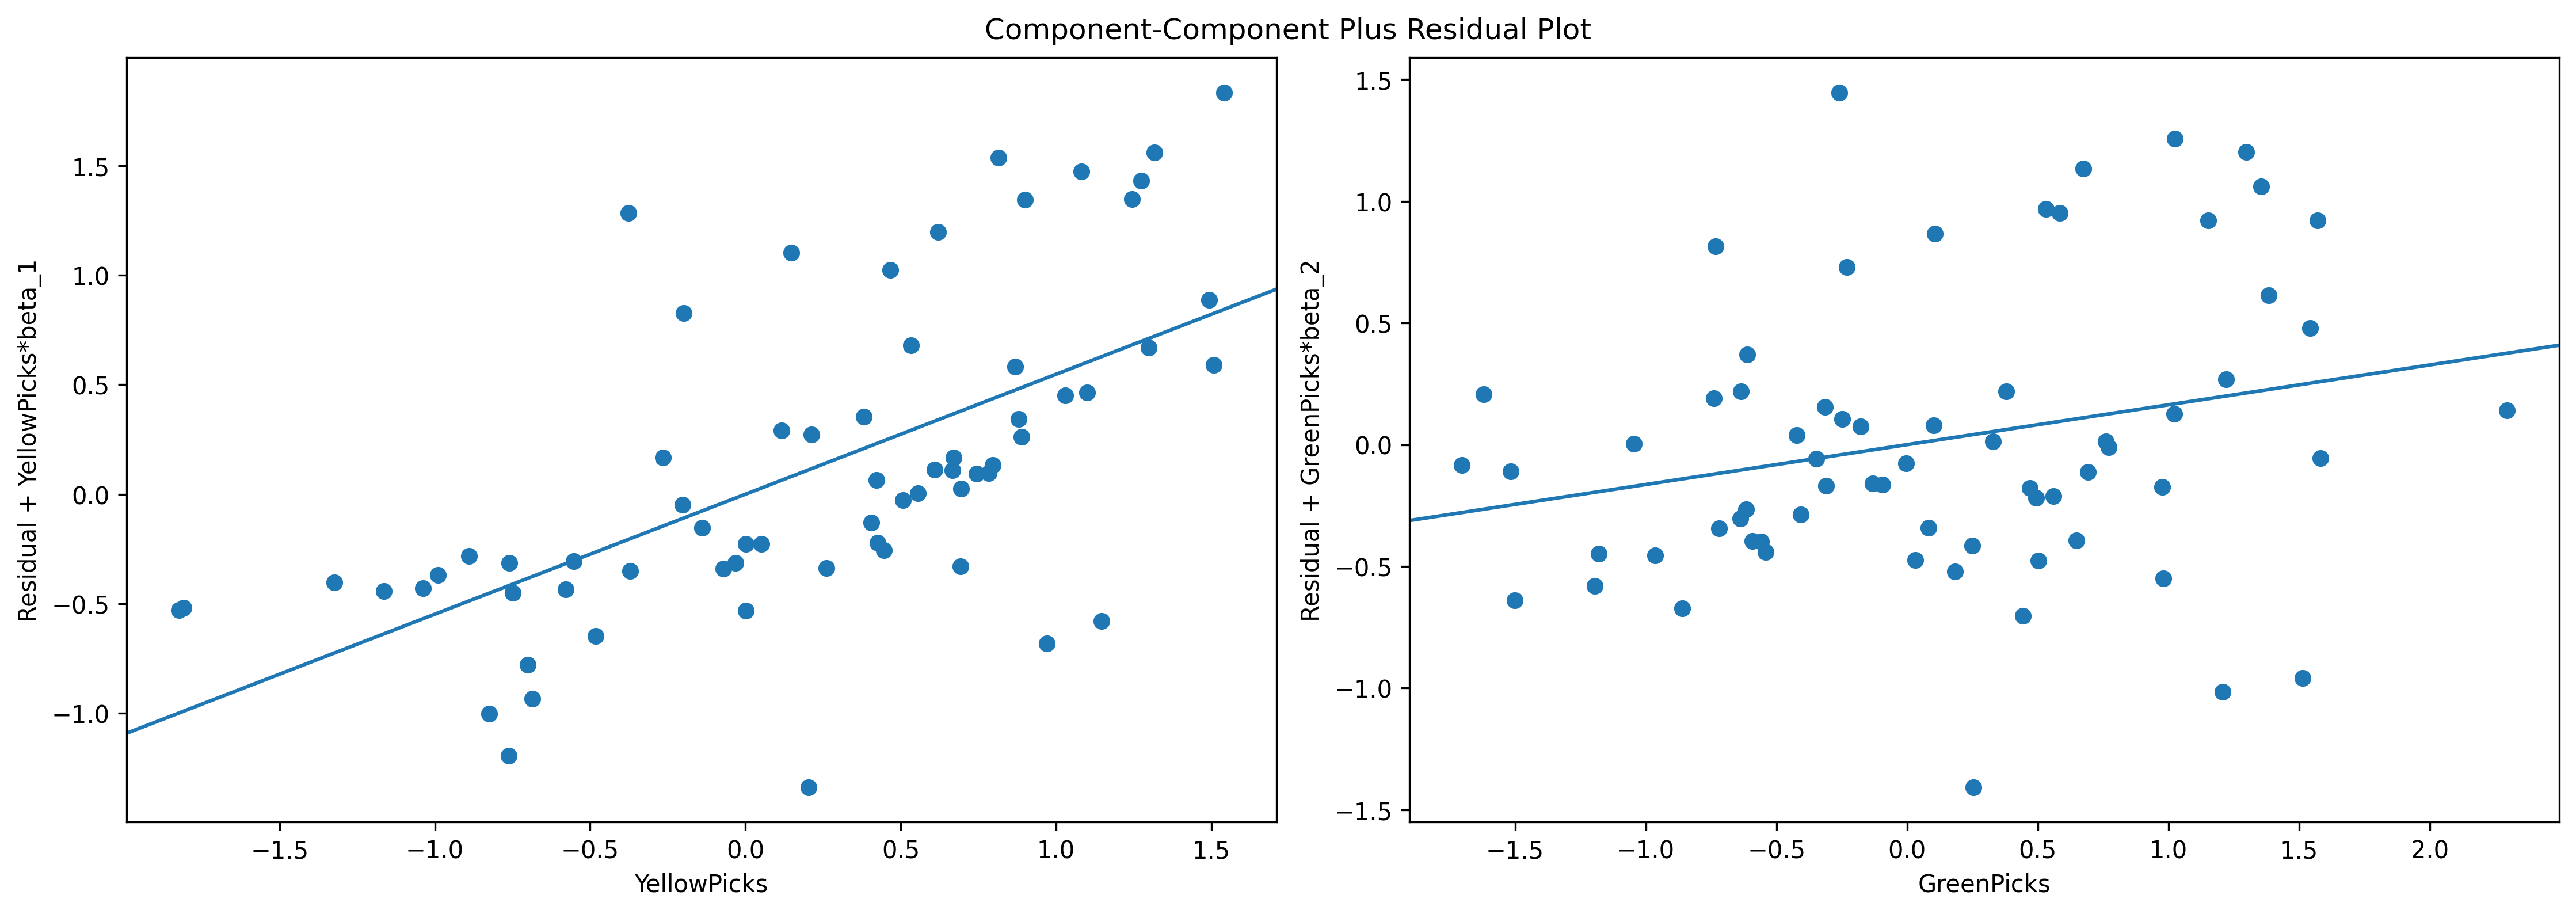

In [94]:
## Y = Selected* + Bi*Xi


fig = sm.graphics.plot_ccpr_grid(lm_removed_best)
fig.tight_layout(pad=1.0)

In [95]:
from statsmodels.tools.eval_measures import rmse

# fit your model which you have already done

# now generate predictions
ypred = lm_removed_best.predict(lm_Date_removed.drop("HVFHVPicks", axis=1))

# calc rmse
rmse = rmse(lm_Date_removed["HVFHVPicks"], ypred)
rmse

0.5639404625287898

## Visualization